In [1]:
import json
from tqdm import tqdm
from typing import Tuple

import argparse
import os.path as osp

import torch
import torch.optim as optim

from torch_geometric.nn import ComplEx

from sklearn.metrics import average_precision_score

import matplotlib.pyplot as plt

import torch_geometric
print("torch_geometric version: ", torch_geometric.__version__)

torch.__version__
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"device: {device}")

/home/fred/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch_geometric version:  2.4.0
device: cuda


In [2]:
%load_ext autoreload
%autoreload 2

from eval import test
from plot import plot_history

In [3]:
from torch_geometric.datasets import WordNet18RR
path = "./data/WN18RR_torch"
data = WordNet18RR(path)[0].to(device)

In [87]:
data

Data(edge_index=[2, 93003], edge_type=[93003], train_mask=[93003], val_mask=[93003], test_mask=[93003], num_nodes=40943)

In [88]:
edge_index = data.edge_index
edge_type = data.edge_type

In [96]:
edge_index, edge_index.shape

(tensor([[    0,     0,     1,  ..., 40933, 40934, 40935],
         [10211, 25525,  3891,  ...,  8943,  8648,  6809]], device='cuda:0'),
 torch.Size([2, 93003]))

In [95]:
edge_type, edge_type.shape

(tensor([ 3,  9, 10,  ...,  3,  3,  3], device='cuda:0'), torch.Size([93003]))

In [109]:
from torch_geometric.data import Data
train_data = Data(edge_index = edge_index[:, data.train_mask],edge_type = edge_type[data.train_mask],num_nodes = data.num_nodes )
valid_data = Data(edge_index = edge_index[:, data.val_mask],  edge_type = edge_type[data.val_mask],  num_nodes = data.num_nodes)
test_data = Data(edge_index = edge_index[:, data.test_mask], edge_type = edge_type[data.test_mask], num_nodes = data.num_nodes)

In [110]:
print(train_data)
print(valid_data)
print(test_data)

Data(edge_index=[2, 86835], edge_type=[86835], num_nodes=40943)
Data(edge_index=[2, 3034], edge_type=[3034], num_nodes=40943)
Data(edge_index=[2, 3134], edge_type=[3134], num_nodes=40943)


In [111]:
torch.save(train_data, './data/WN18RR_torch/train.pt')
torch.save(valid_data, './data/WN18RR_torch/valid.pt')
torch.save(test_data, './data/WN18RR_torch/test.pt')

In [68]:
x = torch.load('/home/fred/Desktop/CS728_A1/data/WN18RR_torch/processed/data.pt')
print('train: ', x[0].train_mask.numpy().sum() )
print('valid: ', x[0].val_mask.numpy().sum() )
print('test:  ', x[0].test_mask.numpy().sum() )
print('total: ', x[0].test_mask.numpy().sum() + x[0].val_mask.numpy().sum() + x[0].train_mask.numpy().sum() )

train:  86835
valid:  3034
test:   3134
total:  93003


In [46]:
# from torch_geometric.loader import DataLoader

# train_loader = DataLoader(train_data, batch_size=1000, shuffle=True)
# val_loader = DataLoader(val_data, batch_size=1000)  # No shuffle for val  
# test_loader = DataLoader(test_data, batch_size=1000)  # No shuffle for test


In [4]:
train_data = torch.load('./data/WN18RR_torch/train.pt')
valid_data = torch.load('./data/WN18RR_torch/valid.pt')
test_data = torch.load('./data/WN18RR_torch/test.pt')

In [6]:
train_data.edge_index

tensor([[    0,     0,     1,  ..., 39607, 39608, 39609],
        [10211, 25525,  3891,  ...,   227,  2995,  7084]], device='cuda:0')

In [11]:
train_data.edge_type.unique()

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')

In [ ]:
# input: [CLS] [MASK] [SEP1] 3 [SEP2] 10211 [END]
# output: subject_id

device: cuda
model.num_nodes: 40943
Epochs: 001 002 003 004 005 

100%|██████████| 3034/3034 [00:05<00:00, 506.71it/s]



Epoch: 005, Val Mean Rank: 13273.57, Val MRR: 0.0199, Val Hits@10: 0.0333, MAP_sk: -1.0000, MAP_scr: -1.0000

Epochs: 006 007 008 009 010 

100%|██████████| 3034/3034 [00:05<00:00, 508.29it/s]



Epoch: 010, Val Mean Rank: 10369.42, Val MRR: 0.0392, Val Hits@10: 0.0728, MAP_sk: -1.0000, MAP_scr: -1.0000

TEST history_freq: 5


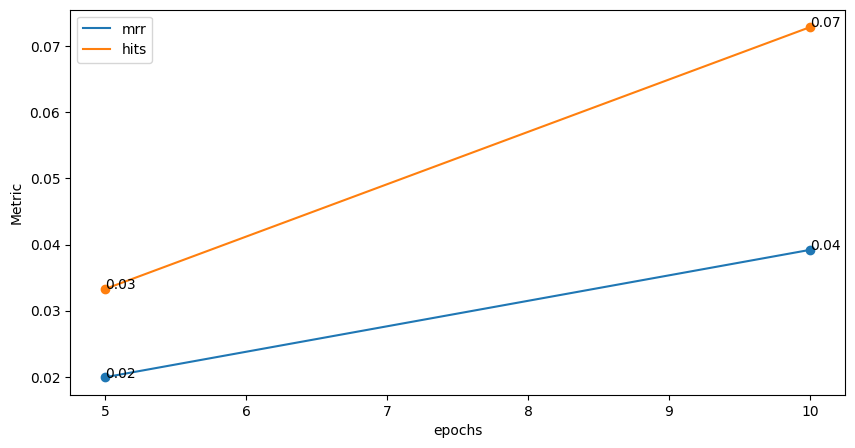

In [28]:
del test, plot_history
from eval import test
from plot import plot_history

import argparse
import os.path as osp

import torch
import torch.optim as optim

from torch_geometric.datasets import WordNet18RR
from torch_geometric.nn import ComplEx
from torch_geometric.data import Data
# from sklearn.metrics import average_precision_score

EPOCHS = 10
history_freq = 5
dataset_name = 'WN18RR_torch'

model_map = {
    'complex': ComplEx,
}

##########
class Args:
  model = 'complex'  # replace with your model choice

args = Args()
#########

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"device: {device}")
# path = osp.join(osp.dirname(osp.realpath(__file__)), '..', 'data', 'FB15k')
path = "./data/WN18RR_torch"

train_data = train_data.to(device)
val_data = valid_data.to(device)
test_data = test_data.to(device)

# model_arg_map = {'rotate': {'margin': 9.0}}

model = ComplEx(
    num_nodes=train_data.num_nodes,
    num_relations=train_data.num_edge_types,
    hidden_channels=50,
    # **model_arg_map.get(args.model, {}),
).to(device)

loader = model.loader(
    head_index=train_data.edge_index[0],
    rel_type=train_data.edge_type,
    tail_index=train_data.edge_index[1],
    batch_size=1000,
    shuffle=True,
)

# optimizer_map = {
#     'transe': optim.Adam(model.parameters(), lr=0.01),
#     'complex': 
#     'distmult': optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-6),
#     'rotate': optim.Adam(model.parameters(), lr=1e-3),
# }
optimizer = optim.Adagrad(model.parameters(), lr=0.001, weight_decay=1e-6)

# @torch.no_grad()
# def test(data):
#     model.eval()
#     return model.test(
#         head_index=data.edge_index[0],
#         rel_type=data.edge_type,
#         tail_index=data.edge_index[1],
#         batch_size=20000,
#         k=10,
#     )


def train():
    model.train()
    total_loss = total_examples = 0
    cnt = 0
    for head_index, rel_type, tail_index in loader:
        # if cnt == 1:
            # print("\nTRAIN:")
            # print(f"head_index: {head_index[0]}, rel_type: {rel_type[0]}, tail_index: {tail_index[0]}\n")
            # print(f"head_index: {head_index}, rel_type: {rel_type}, tail_index: {tail_index}")
        optimizer.zero_grad()
        loss = model.loss(head_index, rel_type, tail_index)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * head_index.numel()
        total_examples += head_index.numel()
        cnt += 1
    return total_loss / total_examples

history = {'rank':[], 'mrr':[], 'hits':[], 'map_sk':[], 'map_scr':[]}

print(f"model.num_nodes: {model.num_nodes}")
print('Epochs: ', end='')
for epoch in range(1, EPOCHS + 1):
    loss = train()
    # print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
    print(f'{epoch:03d} ', end='')
    if epoch % history_freq == 0:
        rank, mrr, hits, map_sk, map_scr = test(model, val_data)
        history['rank'].append(rank)
        history['mrr'].append(mrr)
        history['hits'].append(hits)
        history['map_sk'].append(map_sk)
        history['map_scr'].append(map_scr)
        # rank, hits = test(val_data)
        print(f'\nEpoch: {epoch:03d}, Val Mean Rank: {rank:.2f}, '
              # f'Val Hits@10: {hits:.4f}')
              f'Val MRR: {mrr:.4f}, Val Hits@10: {hits:.4f}, MAP_sk: {map_sk:.4f}, MAP_scr: {map_scr:.4f}')
        print()
        print('Epochs: ', end='') if epoch != EPOCHS else None

        # save history to file
        if 0:
            with open(f"./history/history_epochs_{EPOCHS}_{history_freq}_{dataset_name}.json", "w") as outfile: 
                json.dump(history, outfile)

# rank, mrr, hits_at_10 = test(test_data)
# print(f'Test Mean Rank: {rank:.2f}, Test MRR: {mrr:.4f}, '
#       f'Test Hits@10: {hits_at_10:.4f}')


# print(history)
plot_history({k:v for k,v in history.items() if k not in ['rank', 'map_scr', 'map_sk']}, history_freq)
# plot_history(history, history_freq)

In [ ]:
head_index: 1493, rel_type: 140, tail_index: 3542

plt.plot(history['mrr'])

TEST history_freq: 25


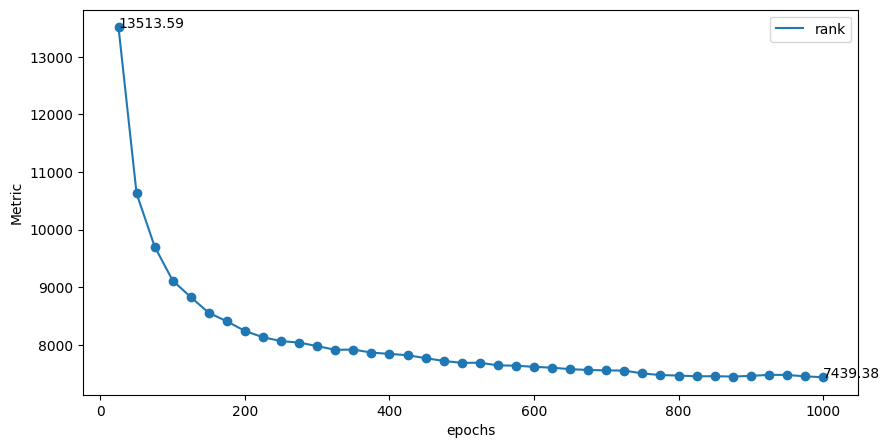

In [25]:
plot_history({'rank': history['rank']})

In [ ]:
plt.scatter([i for i in range(0, len(history['hits']))], history['hits'])
plt.plot(history['hits'])

In [ ]:
plot_history({k:v for k,v in history.items() if k == 'rank'})

In [20]:
# path = osp.join(osp.dirname(osp.realpath(__file__)), '..', 'data', 'FB15k')
path = "./data/FB15k_torch"

train_data = FB15k_237(path, split='train')[0].to(device)
val_data = FB15k_237(path, split='val')[0].to(device)
test_data = FB15k_237(path, split='test')[0].to(device)

Data(edge_index=[2, 272115], edge_type=[272115], num_nodes=14541)

In [25]:
FB15k_237(path, split='train')

IndexError: range object index out of range

In [13]:
from eval import test

In [23]:
del plot_history

In [24]:
from plot import plot_history

ValueError: x and y must have same first dimension, but have shapes (1,) and (20,)

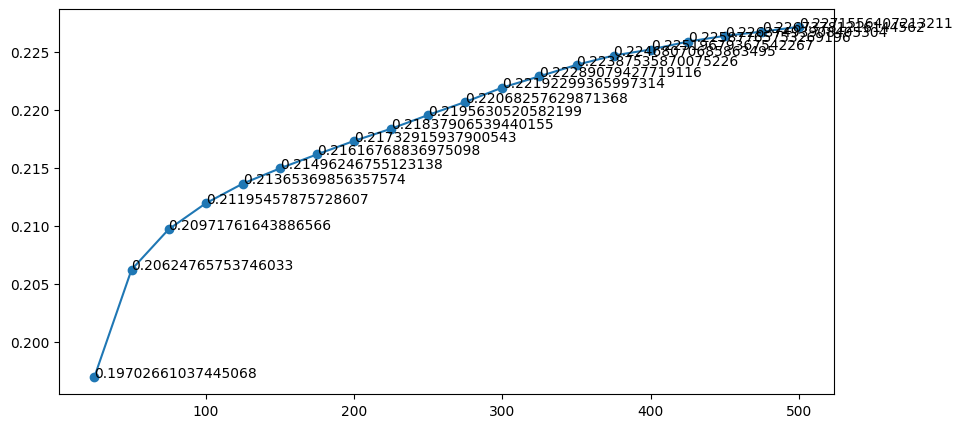

In [3]:
EPOCHS=500
history_freq=25
dataset_name='FB15k_torch'
# Opening JSON file
f = open(f"./history/history_epochs_{EPOCHS}_{history_freq}_{dataset_name}.json")
 
# returns JSON object as 
# a dictionary
data = json.load(f)

# plot_history(data, history_freq)
plot_history({k:v for k,v in data.items() if k not in ['rank', 'map_scr', 'map_sk']}, history_freq)